In [1]:
# Import all of the requried libraries
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
# import statistics
from statistics import mode,mean
from scipy import interpolate
import os

# These are all of the libraries that I manually created
import IOfunctions as IO
import GUIfunctions as GUI
import Processfunctions as process

#
# Through Thorlabs
#
# start_index = 32  # Start index 32 is the full spectrum (from 195nm)
# start_index = 774 # starts at 350nm
#
# Through 3D slicer
#
# start_index = 0 # starts at 195nm
# start_index = 742 # starts at 350nm
start_index = 790 # starts at 360nm
# start_index = 1070 # starts at 420nm



### Data Loading and Formatting 
#### Load in (IO)
* Load in the raw data + baselines and convert it into a useable list of numpy arrays
* Broadband output
* White paper

In [2]:
# This function combines loading the data with 
def loadDataset(dataPath,start_index=790,end_index=-1,sep=','):
    Dataset = []
    print("Loading in: ", dataPath)
    for name in os.listdir(dataPath):
#         print(name)
        df = pd.read_csv(os.path.join(dataPath,name), sep=sep,engine='python', header=None)
        # trim to 360 nm
        df = df.iloc[:, start_index:]
        # convert to an array
        data_arr = df.to_numpy()
        # Sum the columns of the array
        spectrum_arr = np.sum(data_arr[1:, 1:],axis=0)
        # Grab the wavelength values
        wavelength_arr = data_arr[0, 1:]
        # Concatenate the vectors as columns
        data_arr = np.concatenate((wavelength_arr.reshape(-1,1), spectrum_arr.reshape(-1,1)), axis=1)
        # append to the dataset
        Dataset.append(data_arr)
    Dataset = np.array(Dataset,dtype='float')
    return Dataset

# LOADING DATASET 
sampleName0 = 'Beef'
sampleName1 = 'Pork'
trialName = "Nov2022_skinTestData"

# Get the path to the data
dataPath = os.getcwd()
dataPath0 = os.path.join(dataPath,"data",trialName,sampleName0)
dataPath1 = os.path.join(dataPath,"data",trialName,sampleName1)

# Load in the data
data_0 = loadDataset(dataPath0,start_index=start_index, sep=',')
labels_0 = 0*np.ones(len(data_0))
data_1 = loadDataset(dataPath1,start_index=start_index, sep=',')
labels_1 = 1*np.ones(len(data_1))

Loading in:  C:\Spectroscopy_TrackedTissueSensing\data\Nov2022_skinTestData\Beef
Loading in:  C:\Spectroscopy_TrackedTissueSensing\data\Nov2022_skinTestData\Pork


In [3]:
def loadSpectrum(path, col_name=None,start_index=774,end_index=-1,sep=';'):
#     df = pd.read_csv(path + name,sep=';',engine='python')
    df = pd.read_csv(path,sep=sep,engine='python')
#     print(df)
    if not(col_name == None):
        df[col_name] = df.index
    data = df[start_index:end_index]
#     print(data)
    data_arr = data.to_numpy()
    data_arr = np.array(data_arr,dtype='float')
    return data_arr

# LOAD IN BASELINES
dataPath = os.getcwd()
folderName = 'March2022_raw_data'
file_name = 'white_baseline.csv'
dataPath_Paper = os.path.join(dataPath,"data",folderName,file_name)
baseline_pap = loadSpectrum(dataPath_Paper, 'Wavelength', start_index=821)

dataPath = os.getcwd()
folderName = 'March2022_raw_data'
file_name = 'SLS201L_Spectrum_reformatted.csv'
dataPath_BrOut = os.path.join(dataPath,"data",folderName,file_name)
print(dataPath_BrOut)
baseline_BrOut_raw = loadSpectrum(dataPath_BrOut, 'Wavelength', start_index=10, end_index=675, sep=',')
# Interpolate such that the downloaded spectrum has the same values of the data
x = baseline_BrOut_raw[:,0]
y = baseline_BrOut_raw[:,1]
f = interpolate.interp1d(x,y)
xnew = data_0[0,:,0]
ynew = f(xnew)
baseline_BrOut = np.transpose(np.array([xnew,ynew]))
print(baseline_BrOut.shape)
print('Data shape', data_0.shape)
print(np.min(baseline_BrOut))

C:\Spectroscopy_TrackedTissueSensing\data\March2022_raw_data\SLS201L_Spectrum_reformatted.csv
(2858, 2)
Data shape (36, 2858, 2)
0.006687616446553936


360.14014912872346


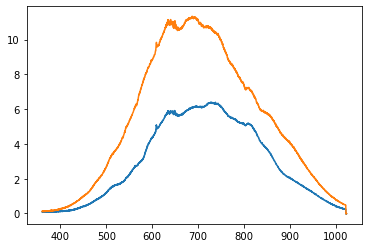

In [4]:
plt.plot(data_0[0,:,0],data_0[0,:,1])
plt.plot(data_1[0,:,0],data_1[0,:,1])
data_0.shape
print(data_0[0,0,0])

### Display the raw data
* Display a pork and chicken sample
* Display the broadband source output

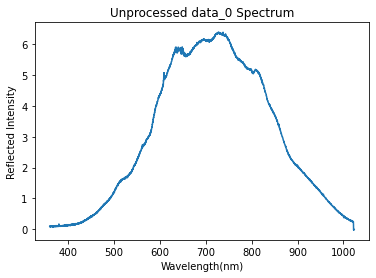

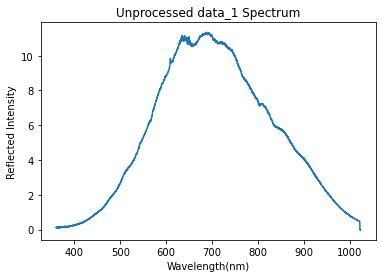

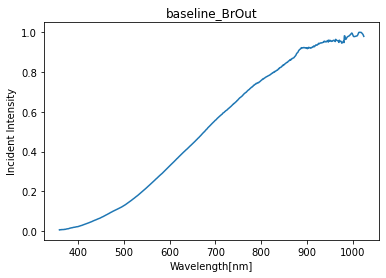

In [5]:
# Displaying all of the spectra to visually inspect results

# GUI.plotall(data_0)
# GUI.plotall(data_1)

# This should be in GUI with all the inputs as parameters
wavelength_start = data_0[0,0,0]
wavelength_end = data_0[0,-1,0]

w = np.linspace(wavelength_start,wavelength_end,len(data_0[1]))
# Display an example of data_0
GUI.plotSpectra(xdata=data_0[0,:,0],ydata=data_0[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_0 Spectrum')
# Display an example of data_1
GUI.plotSpectra(xdata=data_1[0,:,0], ydata=data_1[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Unprocessed data_1 Spectrum' )
# # Display an example of paper
# GUI.plotSpectra(xdata=baseline_pap[:,1],ydata=baseline_pap[:,0],xlab="Wavelength[nm]",
#             ylab='Reflected Intensity',title='baseline_pap')
# Display an example of broadband output
GUI.plotSpectra(xdata=baseline_BrOut[:,0],ydata=baseline_BrOut[:,1],xlab="Wavelength[nm]",
            ylab='Incident Intensity',title='baseline_BrOut')

In [6]:
# Find a list of the max values in the training set
max_values = []
for i in range(len(data_0[:,0,0])):
    max_values.append(np.max(data_1[i,:,1]))
# Remove all spectra with a max value less then 0.1 and more than 0.99
# plt.plot(max_values)
# print(max_values)
# plt.figure()
# plt.plot(np.transpose(data_0[:,:,1]))

### Preprocessing of the data
* Crop to 360nm to 1024nm
* Normalize (MinMax norm)
* Subtract the normalized broadband output
* Dimensionality reduction
* Max binning?

(36, 2578, 2)
(2578,)


Text(0.5, 1.0, 'Signal with broadband transfer function removed')

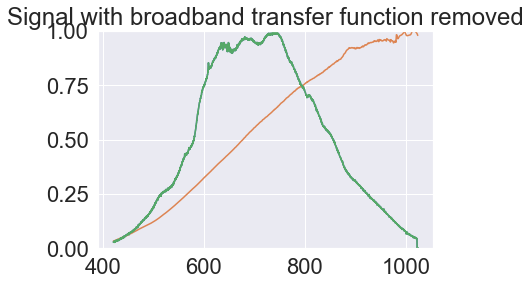

In [20]:
FLAG_Baseline = False
# Load in the baseline 
baseline = baseline_BrOut # --------------------------------- flag
# baseline = baseline_pap[:,:]
baseline = process.normalize(baseline)[:,1]

data_norm = data_0[:,280:,:].copy()
baseline = baseline[280:].copy()

# Normalize the peak of the signal to 1. This allows us to find the proportional height above the baseline
data_norm = process.normalize(data_norm)
# Arguments
inputData = data_norm
tFunc = baseline
print(inputData.shape)
print(tFunc.shape)

flag = FLAG_Baseline
def divTfuc(inputData,tFunc, flag):    
    outputData = inputData.copy()
    if FLAG_Baseline:
        # For each spectra
        for i in range (inputData[:,:,1].shape[0]):
            data = inputData[i,:,1]
            # Divide by the baseline transfer function
            outputData[i,:,1] = data / tFunc 
    outputData = process.normalize(outputData)
    return outputData
# call the function
outputData = divTfuc(inputData,tFunc, flag)
# Display the arguemtns and output
freq = data_norm[0,:,0]
plt.figure()
plt.plot(freq,inputData[35,:,1]) 
plt.plot(freq,tFunc)
plt.plot(freq,outputData[35,:,1])
plt.ylim([0,1])
plt.title('Signal with broadband transfer function removed')

In [21]:
# Normalize all data
data_0_norm = divTfuc(data_0[:,280:,:], baseline,FLAG_Baseline)
data_0_saved = data_0_norm.copy()
print('shape:', data_0_norm.shape)
# data_0_norm = process.subtractBaseline(data_0_norm,baseline)
# data_0_norm = process.normalize(data_0_norm)

data_1_norm = divTfuc(data_1[:,280:,:], baseline,FLAG_Baseline)
data_1_saved = data_1_norm.copy()

print('Size of data_0,', data_0_norm.shape)
print('Size of data_1,', data_1_norm.shape)
print(tFunc.min())


shape: (36, 2578, 2)
Size of data_0, (36, 2578, 2)
Size of data_1, (36, 2578, 2)
0.03321808470462091


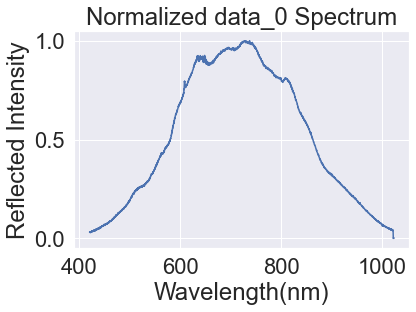

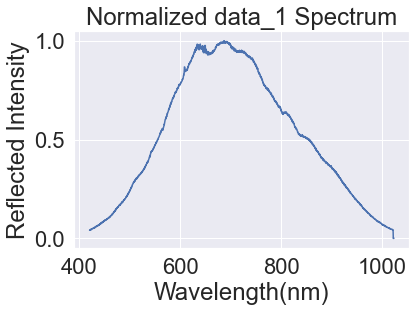

In [22]:
# Plots of the normalized spectra
GUI.plotSpectra(xdata=data_0_norm[0,:,0],ydata=data_0_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_0 Spectrum' )
GUI.plotSpectra(xdata=data_1_norm[0,:,0],ydata=data_1_norm[0,:,1],xlab='Wavelength(nm)',ylab='Reflected Intensity',
                title='Normalized data_1 Spectrum' )

# Training and Testing

### Stratify data

In [23]:
# This function takes in the beef,chicken,pork, and turkey data
def stratdata(class0,class1,case):
    # Break each into 
    c0_1,c0_2,c0_3,c0_4 = chunkData6by6(class0)
    c1_1,c1_2,c1_3,c1_4 = chunkData6by6(class1)
    
    d1 = np.concatenate([c0_1,c1_1])
    d2 = np.concatenate([c0_2,c1_2])
    d3 = np.concatenate([c0_3,c1_3])
    d4 = np.concatenate([c0_4,c1_4])
    
    # implement a switch-case
    if case == 1:
        train = np.concatenate([d1,d2])
        val   = d3
        test  = d4
    elif case == 2:
        train = np.concatenate([d1,d3])
        val   = d2
        test  = d4
    elif case == 3:
        train = np.concatenate([d2,d3])
        val   = d1
        test  = d4
    elif case == 4:
        train = np.concatenate([d1,d2])
        val   = d4
        test  = d3
    elif case == 5:
        train = np.concatenate([d1,d4])
        val   = d2
        test  = d3
    elif case == 6:
        train = np.concatenate([d2,d4])
        val   = d1
        test  = d3
    elif case == 7:
        train = np.concatenate([d1,d4])
        val   = d3
        test  = d2
    elif case == 8:
        train = np.concatenate([d1,d3])
        val   = d4
        test  = d2
    elif case == 9:
        train = np.concatenate([d4,d3])
        val   = d1
        test  = d2
    elif case == 10:
        train = np.concatenate([d2,d4])
        val   = d3
        test  = d1
    elif case == 11:
        train = np.concatenate([d3,d4])
        val   = d2
        test  = d1
    elif case == 12:
        train = np.concatenate([d2,d3])
        val   = d4
        test  = d1
    else:
        print("Invalid case selected!")
    
    return train,val,test

# Breaks the data into 4 corner chunks
def chunkData6by6(data):    
    data = data.copy()
    d1 = data[[0,1,2,6,7,8,12,13,14]]
    d2 = data[[3,4,5,9,10,11,15,16,17]]
    d3 = data[[18,19,20,24,25,26,30,31,32]]
    d4 = data[[21,22,23,27,28,29,33,34,35]]
    return d1,d2,d3,d4

# This function simply breaks the data into 4 chunks based on the number of samples
def chunkDataSimple(dataIn):
    data = dataIn.copy()
    # Get the length of the data
    length = data.shape[0]
    # Break the data into 4 chunks of equal length
    d1 = data[0:int(length/4)]
    d2 = data[int(length/4):int(length/2)]
    d3 = data[int(length/2):int(3*length/4)]
    d4 = data[int(3*length/4):length]     
    return d1,d2,d3,d4
    

#X_train, X_val, X_test = stratdata(B_data,C_data,P_data,T_data,1)
#y_train, y_val, y_test = stratdata(B_labels,C_labels,P_labels,T_labels,1)

In [24]:
# plt.plot(np.transpose(data_0_norm[:,:,1]))
# plt.plot(np.transpose(data_1_norm[:,:,1]))

print(data_0_norm.shape)
print(labels_0.shape)
print(data_1_norm.shape)
print(labels_1.shape)


(36, 2578, 2)
(36,)
(36, 2578, 2)
(36,)


### Train ML models

In [25]:
# This is revamped to just train the classifier and save it
import sklearn
print("sklearn version: ",sklearn.__version__)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score,roc_auc_score

inferenceFlag = False 
# if the model is being trained for inference in 3D slicer, use all the data
if inferenceFlag is True:
    X_train = np.concatenate([data_0_norm[:,:,1],data_1_norm[:,:,1]])
    y_train = np.concatenate([labels_0,labels_1])

    # Instantiate the model
    modelKNN = KNeighborsClassifier(n_neighbors=3)

    # Train the model
    modelKNN.fit(X_train,y_train)

    # Save the model to file
    from joblib import dump, load
    dump(modelKNN, 'Models/KNN_faketrails.joblib') 

sklearn version:  1.1.1


In [26]:
# GUI
import seaborn as sns
def fancyConfusionMatrix(cf_matrix, classifierName):
    # ax = sns.heatmap(cf_matrix/sum(cf_matrix), annot=True, fmt='.2%',cmap='Blues')
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix,axis=1), annot=True, cmap='Blues')
    sns.set(font_scale=2)
    titleFontSize = 20
    ax.set_title(classifierName+' Confusion Matrix',fontsize=titleFontSize)
    ax.set_xlabel('\nPredicted Values', fontsize=titleFontSize)
    ax.set_ylabel('Actual Values', fontsize=titleFontSize)

    # Ticket labels - List must be in alphabetical order
    tickFontSize = 16
    ax.xaxis.set_ticklabels(['Beef', 'Pork'], fontsize=tickFontSize)
    ax.yaxis.set_ticklabels(['Beef', 'Pork'], fontsize=tickFontSize)

    # Display the visualization of the Confusion Matrix.
    plt.show()

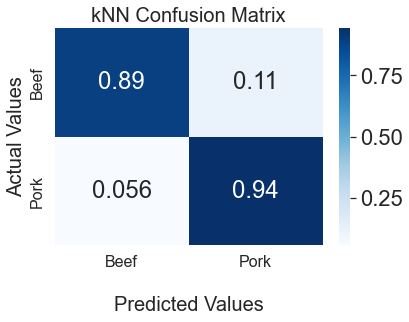

The mean f1 score is:  0.9162334451324387
The mean accuracy is:  0.9166666666666666


In [27]:
# Training of the KNN
F1s = []
Accs = []
cf_matrix = 0

# if the model is being tested then stratify the data into train, test, split
if inferenceFlag is False:
    for i in range(1,13):
        X_train, X_val, X_test = stratdata(data_0_norm[:,:,1],data_1_norm[:,:,1],case=i)
        y_train, y_val, y_test = stratdata(labels_0,labels_1,case=i)
        # Combine training and validation as there is no validation
        X_train = np.concatenate([X_train,X_val])
        y_train = np.concatenate([y_train,y_val])
        # Instantiate the model
        modelKNN = KNeighborsClassifier(n_neighbors=3)
        # Train the model
        modelKNN.fit(X_train,y_train)
        # Test the model
        predicted = modelKNN.predict(X_test)       
        F1s.append(f1_score(y_test,predicted,average='weighted'))
        Accs.append(accuracy_score(y_test,predicted))
        cf_matrix += confusion_matrix(y_test, predicted)
    
#     print(cf_matrix/sum(cf_matrix)) 
    fancyConfusionMatrix(cf_matrix,'kNN')
#     print(cf_matrix)
#     plt.figure()
#     plt.plot(np.transpose(X_train))
#     print('F1s', F1s)
    print('The mean f1 score is: ',np.mean(F1s))
    print('The mean accuracy is: ',np.mean(Accs))

In [28]:
# # Training of the SVM
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score,roc_auc_score

# F1s = []
# Accs = []
# cf_matrix = 0
# # if the model is being tested then stratify the data into train, test, split
# if inferenceFlag is False:
#     for i in range(1,13):
#         X_train, X_val, X_test = stratdata(data_0_norm[:,:,1],data_1_norm[:,:,1],case=i)
#         y_train, y_val, y_test = stratdata(labels_0,labels_1,case=i)
#         # Combine training and validation as there is no validation
#         X_train = np.concatenate([X_train,X_val])
#         y_train = np.concatenate([y_train,y_val])
#         # Instantiate the model
#         modelSVM = SVC()
#         # Train the model
#         modelSVM.fit(X_train,y_train)
#         # Test the model
#         predicted = modelSVM.predict(X_val) 
#         F1s.append(f1_score(y_test,predicted,average='weighted'))
#         Accs.append(accuracy_score(y_test,predicted))
#         cf_matrix += confusion_matrix(y_test, predicted)
        
#     fancyConfusionMatrix(cf_matrix, 'SVM')
# #     print(cf_matrix/sum(cf_matrix))    
# #     plt.figure()
# #     plt.plot(np.transpose(X_train))
# #     print('F1s', F1s)
#     print('The mean f1 score is: ',np.mean(F1s))
#     print('The mean accuracy is: ',np.mean(Accs))


In [ ]:
### Used for producing SPIE figure

# # load('Models/KNN_PorkVsBeefTest.joblib')
# import seaborn as sns
# import sklearn
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score,roc_auc_score
# from random import Random

# # ax = sns.heatmap(cf_matrix/sum(cf_matrix), annot=True, fmt='.2%',cmap='Blues')
# green = 0*np.ones(223)
# red   = 1*np.ones(191)
# y_test = np.concatenate([green,red])

# TN = 0*np.ones(205)
# FP = 1*np.ones(18)
# TP = 1*np.ones(182)
# FN = 0*np.ones(9)
# predicted = np.concatenate([TN,FP,TP,FN])

# cf_matrix = confusion_matrix(y_test, predicted)

# ax = sns.heatmap(cf_matrix/sum(cf_matrix), annot=True, cmap='Blues')
# # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')


# # ax.set_title('kNN Confusion Matrix');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');

# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['Pork','Beef'])
# ax.yaxis.set_ticklabels(['Pork','Beef'])

# # ax.xaxis.set_ticklabels(['False','True'])
# # ax.yaxis.set_ticklabels(['False','True'])

# ## Display the visualization of the Confusion Matrix.
# plt.show()

# plt.savefig('ConfusionMatrix_KNN_PorkVsBeefTest.png')